In [ ]:


from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model


In [ ]:

SIZE=496
img_data=[]


In [ ]:

img=cv2.imread('/content/drive/MyDrive/500g/images/cropped_Bhattacharya_Frery_BF4_RGB.bmp.1000_2000.png_0_0.png', 1)   #Change 1 to 0 for grey images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.


In [ ]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    encoded = conv_block(p4, 1024) #Bridge

    return encoded

#Decoder for Autoencoder ONLY.
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)

    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder.
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

# model=build_autoencoder((256, 256, 3))
# print(model.summary())

#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    print(model.summary())
    return model

In [ ]:

model=build_autoencoder(img.shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(model.summary())


model.fit(img_array, img_array,
        epochs=1000,
        shuffle=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 496, 496, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 496, 496, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 496, 496, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 496, 496, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 496, 496, 64)     256       
 hNormalization)                                             

1/1 [==============================] - 0s 376ms/step


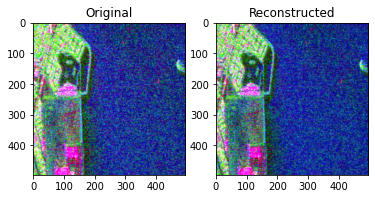

In [ ]:


pred = model.predict(img_array)

#pred_u8 = (pred[0].reshape(128,128,3)).astype(np.uint8)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()


1/1 [==============================] - 1s 556ms/step


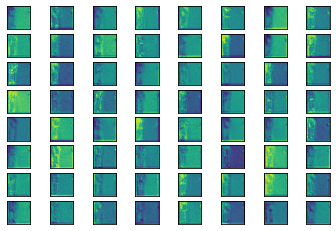

In [ ]:

model2 = build_autoencoder(img.shape)


my_model = model2

#set intermediate representations for all layers in the model
# except for the first - as it is an input layer
outputs = [layer.output for layer in my_model.layers[1:]]

model_for_visualization = Model(inputs = my_model.input, outputs = outputs)

#Generate random image to be used as input
# img = np.uint8(np.random.uniform(120, 200, (256, 256, 3)))/255
# input_img = np.expand_dims(img, axis=0)

input_img = img_array
feature_maps = model_for_visualization.predict(input_img)

#layer_names = [layer.name for layer in model2.layers]

# plot all 64 maps in an 8x8 squares
#import random
#layer_num = random.randint(0, len(feature_maps)-1)
layer_num = 32 #Depth of layer...
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[layer_num][0, :, :, ix-1])
		ix += 1
# show the figure
plt.show()